# Periodic Data

If you can correctly guess the periodicity of your fluctuation, it seems that you can fit a linear model quite well by using a feature $x \rightarrow [x,sin(x),cos(x)]$.

This might be better than using categorical features (Monday, Tuesday, ...) because the model understands periodicity and ordering, i.e. that a Monday follows on a Sunday, and because it is able to fit the intermediate case of "Monday 0:01am". Moreover, instead of having 7 categorical features there are only two additional continuous features, so the dimensionality of the feature space is lower here. 

Below is some experimentation that isn't rigorous at all. It does look like the periodic regression performs consistently better than a binned and a linear regression on artificial data that is a sine wave on top of a linear trend.

For a linear model, I would expect that the periodic regression would have trouble for erratic variations across week days. The binned model, on the other hand, fits fully independent parameters for each time bin. A nonlinear model should not have that problem though, and this is interesting to explore! 

The model does not seem to care about phase shifts, which makes sense.

The model appears highly sensitive to guessing the right periodicity, which applies to the binned case the same. In so far, this type of model is probably only appropriate when the periodicity is fixed and known (i.e. months in a year, weeks, etc.).

I'm probably just clumsily reinventing something like "Fourier Regression" or something like that.

Text(0.5, 1.0, 'weekly cycle')

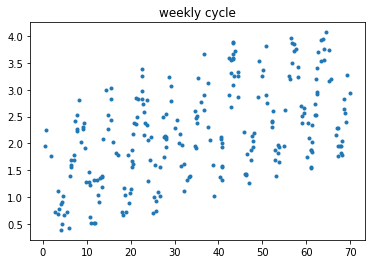

In [1]:
import numpy as np
import matplotlib.pyplot as plt

weekly_fluctuation = 1
daily_fluctuation = 0.5
trend = 0.025
noise = 0.275
N = 250

x = np.random.uniform(low=0,high=10*7,size=N)
y = np.abs(1+weekly_fluctuation*np.sin(2*np.pi*(x+np.random.randn()*7)/7) + daily_fluctuation*np.abs(np.sin(2*np.pi*x/2)) + noise*np.random.normal(size=N)) + trend*x

plt.plot(x,y,'.')
plt.title('weekly cycle')

Text(0.5, 1.0, 'weekly cycle')

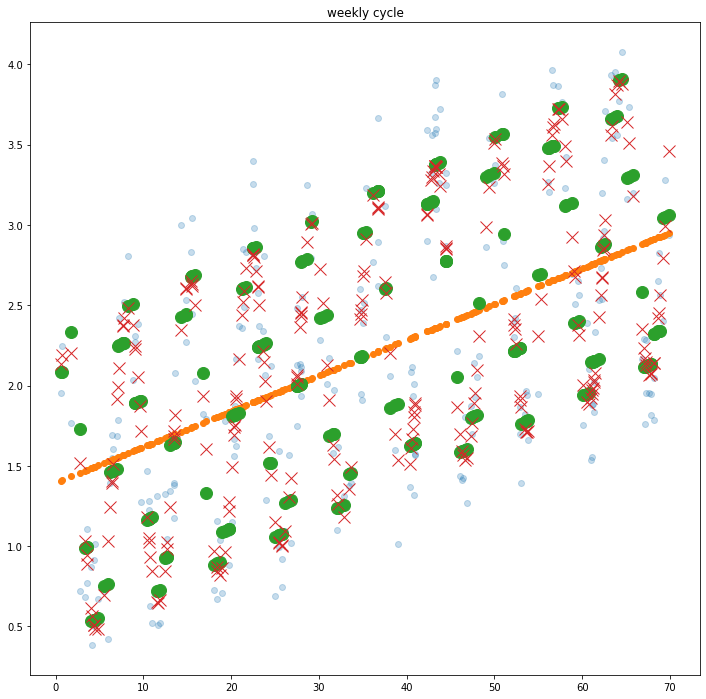

In [2]:
from sklearn.linear_model import LinearRegression


naive_reg = LinearRegression().fit(x.reshape(-1,1),y.reshape(-1,1))

day_dict = {day:7*[0] for day in range(7)}
for day in day_dict:
    day_dict[day][day%7]=1
    
binned_features = np.hstack([x.reshape(-1,1),np.array([day_dict[int(t)%7] for t in x])])
binned_reg = LinearRegression().fit(binned_features,y.reshape(-1,1))

periodic_features = np.vstack([x,np.sin(2*np.pi*x/7),np.cos(2*np.pi*x/7)]).T
periodic_reg = LinearRegression().fit(periodic_features,y.reshape(-1,1))

plt.figure(figsize=(12,12))
plt.plot(x,y,'o',alpha=0.25)
plt.plot(x,naive_reg.predict(x.reshape(-1,1)),'.',markersize=12)
plt.plot(x,binned_reg.predict(binned_features),'o',markersize=12)
plt.plot(x,periodic_reg.predict(periodic_features),'x',markersize=12)
plt.title('weekly cycle')

In [3]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y,naive_reg.predict(x.reshape(-1,1))))
print(mean_squared_error(y,binned_reg.predict(binned_features)))
print(mean_squared_error(y,periodic_reg.predict(periodic_features)))

0.5661716419239758
0.11574156617360808
0.09469833816081434


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


class BinnedRegression(LinearRegression):
    def __init__(self,*args,**kwargs):
        #super().__init__()
        self.reg = LinearRegression()
        
    def get_params(self,*args,**kwargs):
        return self.reg.get_params(*args,**kwargs)
    
    def transform_features(self,x):
        return np.hstack([x.reshape(-1,1),np.array([int(t%self.periodicity) for t in x]).reshape(-1,1)])
    
    def fit(self,x,y,periodicity):
        self.periodicity = periodicity
        self.reg.fit(self.transform_features(x),y)
        
    def predict(self,x):
        return self.reg.predict(self.transform_features(x))
        
    
class PeriodicRegression(BinnedRegression):
    def transform_features(self,x):
        return np.hstack([x.reshape(-1,1),np.sin(2*np.pi*x/self.periodicity).reshape(-1,1),np.cos(2*np.pi*x/self.periodicity).reshape(-1,1)])
    

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


weekly_fluctuation = 1
daily_fluctuation = 0.5
trend = 0.025
noise = 0.275
N = 250

binned_r2 = []
periodic_r2 = []
linear_r2 = []

assumed_periodicities = range(1,30)
for assumed_periodicity in assumed_periodicities:
    
    x = np.random.uniform(low=0,high=10*7,size=N).reshape(-1,1)
    y = np.abs(1+weekly_fluctuation*np.sin(2*np.pi*(x+np.random.randn()*7)/7) + daily_fluctuation*np.abs(np.sin(2*np.pi*x/2)) + noise*np.random.normal(size=N)) + trend*x

    binned_r2.append(np.mean(cross_val_score(BinnedRegression(assumed_periodicity),x,y,scoring='r2',cv=15,n_jobs=4,fit_params={'periodicity':assumed_periodicity})))
    periodic_r2.append(np.mean(cross_val_score(PeriodicRegression(assumed_periodicity),x,y,scoring='r2',cv=15,n_jobs=4,fit_params={'periodicity':assumed_periodicity})))
    linear_r2.append(np.mean(cross_val_score(LinearRegression(),x,y,scoring='r2',cv=15,n_jobs=4)))
    
    
ax1.semilogy(assumed_periodicities,linear_r2,'o-')
ax1.semilogy(assumed_periodicities,binned_r2,'o-')
ax1.semilogy(assumed_periodicities,periodic_r2,'o-')

ax1.set_title("R2 score vs. assumed periodictiy")
ax1.legend("linear,binned,periodic".split(','))




binned_r2 = []
periodic_r2 = []
linear_r2 = []

data_per_period = np.linspace(1,100,200)
for density in data_per_period:
    
    N = 10*density
    x = np.random.uniform(low=0,high=10*7,size=int(N)).reshape(-1,1)
    y = np.abs(1+weekly_fluctuation*np.sin(2*np.pi*(x+np.random.randn()*7)/7) + daily_fluctuation*np.abs(np.sin(2*np.pi*x/2)) + noise*np.random.normal(size=int(N))) + trend*x

    binned_r2.append(np.mean(cross_val_score(BinnedRegression(periodicity=7),x,y,scoring='r2',cv=5,n_jobs=4,fit_params={'periodicity':7})))
    periodic_r2.append(np.mean(cross_val_score(PeriodicRegression(periodicity=7),x,y,scoring='r2',cv=5,n_jobs=4,fit_params={'periodicity':7})))
    linear_r2.append(np.mean(cross_val_score(LinearRegression(),x,y,scoring='r2',cv=5,n_jobs=4)))
    
    
    
ax2.semilogy(data_per_period,linear_r2)
ax2.semilogy(data_per_period,binned_r2)
ax2.semilogy(data_per_period,periodic_r2)

ax2.set_title("R2 score vs. data points/period")
ax2.legend("linear,binned,periodic".split(','))